<a href="https://colab.research.google.com/github/GuilhermePelegrina/Mackenzie/blob/main/TCCs%20/Integra%C3%A7%C3%A3o%20previs%C3%A3o%20de%20demanda%20e%20gest%C3%A3o%20de%20estoques/main_modelo_integracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UMA ABORDAGEM INTEGRADA PARA ANALISAR A EFICIÊNCIA NA PREVISÃO DE DEMANDA E NA GESTÃO DE ESTOQUE COM FERRAMENTAS DE CIÊNCIA DE DADOS**

# *Autores: Anônimo*

Este código faz a integração da previsão de demanda (usando os algoritmos da Regressão Linear e ARIMA, com ou sem variável exógena) com a gestão de estoques. Para essa análise, o código considera uma parcela dos dados para treinar o modelo e os últimos períodos (definidos pelo usuário) para avaliar e comparar os resultados obtidos com as demandas reais.

Execute a célula de códigos abaixo para ler as bibliotecas e funções.

In [9]:
#@markdown Execute essa célula!

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import acf
from statsmodels.graphics.tsaplots import pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
import itertools
from google.colab import files
import os
import csv
import warnings
warnings.filterwarnings('ignore')

# Leitura de dados
def leitura_dados():
  print('Selecione o arquivo que contém a base de dados')
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('Arquivo "{name}" carregado, com tamanha {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

  arquivo = fn
  extensao = os.path.splitext(arquivo)[1]

  if extensao == '.xlsx':
    dados = pd.read_excel(arquivo)

  elif extensao == '.csv':

    caminho_arquivo = arquivo

    with open(caminho_arquivo, 'r', newline='', encoding='utf-8') as f:
        amostra = f.read(1024)  # lê um pedaço do arquivo
        separador_detectado = csv.Sniffer().sniff(amostra).delimiter

    dados = pd.read_csv(arquivo, sep = separador_detectado)

  colunas = dados.columns

  print()
  print('Indique, informando o número correspondente, a coluna que contém a informação sobre o tempo:')
  print()
  for ii in range(len(colunas)):
    print(ii, ': ', colunas[ii])
  indice_periodo = int(input('Coluna com informação sobre o tempo: '))

  dados['Data'] = pd.to_datetime(dados[colunas[indice_periodo]])
  dados['Data'] = dados['Data'].dt.to_period('M')
  dados['Data'] = dados['Data'].dt.strftime('%Y-%m')
  dados.set_index('Data', inplace=True)

  colunas = dados.columns

  print()
  print('Indique, informando o número correspondente, a coluna que contém a série temporal (demanda):')
  print()
  for ii in range(len(colunas)):
    print(ii, ': ', colunas[ii])
  indice_serie = int(input('Coluna com a série temporal (demanda): '))

  demanda = pd.DataFrame(dados[colunas[indice_serie]])

  print()
  print('Há alguma variável exógena? Se sim, indique, informando o número correspondente, a coluna que contém a variável exógena. Caso contrário, digite 99.')
  print()
  for ii in range(len(colunas)):
    print(ii, ': ', colunas[ii])
  indice_exog = int(input('Coluna com a variável exógena: '))

  # Quantidade de amostras a serem previstas (últimos n valores)
  print()
  Nprev = int(input('Indique o número de períodos a serem previstos: '))

  # Dados de treinamento e de teste (previsão)
  demanda_train = demanda.iloc[0:-Nprev]
  demanda_test = demanda.iloc[-Nprev:]

  if indice_exog == 99:
    exogena = None
    exog_train = None
    exog_test = None
  else:
    exogena = pd.DataFrame(dados[colunas[indice_exog]])
    exog_train = exogena.iloc[0:-Nprev]
    exog_test = exogena.iloc[-Nprev:]

  # Parâmetros de entrada: lead time e lote mínimo
  print()
  lt = float(input('Indique o lead time de produção/importação: '))

  print()
  lm = float(input('Indique o lote mínimo de produção/importação: '))

  print()
  em = int(input('Indique o estoque mínimo (de segurança) do produto: '))

  parametros = pd.DataFrame([{'lead_time': lt, 'lote_minimo': lm, 'estoque_minimo': em}])

  # Plot da série temporal (completa)
  plt.figure(figsize=(20,5))
  plt.plot(demanda)
  plt.title(f'Demanda - {colunas[indice_serie]}')
  plt.xticks(rotation=45)
  plt.show()

  return dados,demanda,demanda_train,demanda_test,colunas,Nprev,indice_serie,exogena,exog_train,exog_test,parametros

# Regressão linear
def regressao_linear(demanda_train,demanda_test,dados,colunas,indice_serie,exogena,exog_train,exog_test):

  # Cria um vetor com os valores temporais
  demanda_train['tempo'] = np.arange(len(demanda_train))
  demanda_test['tempo'] = np.arange(len(demanda_train),len(demanda_train)+len(demanda_test))

  # Cria o modelo de regressão linear e faz as previsões
  if exog_train is None:
    reg_lin = LinearRegression().fit(np.array(pd.concat([demanda_train['tempo'],exog_train],axis=1)).reshape(-1, 1),np.array(demanda_train[colunas[indice_serie]]).reshape(-1, 1))
    previsoes_train = reg_lin.predict(np.array(pd.concat([demanda_train['tempo'],exog_train],axis=1)).reshape(-1, 1))
    previsoes_test = reg_lin.predict(np.array(pd.concat([demanda_test['tempo'],exog_test],axis=1)).reshape(-1, 1))
    score_train = reg_lin.score(np.array(pd.concat([demanda_train['tempo'],exog_train],axis=1)).reshape(-1, 1), np.array(demanda_train[colunas[indice_serie]]).reshape(-1, 1))

  else:
    reg_lin = LinearRegression().fit(np.array(pd.concat([demanda_train['tempo'],exog_train],axis=1)),np.array(demanda_train[colunas[indice_serie]]).reshape(-1, 1))
    previsoes_train = reg_lin.predict(np.array(pd.concat([demanda_train['tempo'],exog_train],axis=1)))
    previsoes_test = reg_lin.predict(np.array(pd.concat([demanda_test['tempo'],exog_test],axis=1)))
    score_train = reg_lin.score(np.array(pd.concat([demanda_train['tempo'],exog_train],axis=1)), np.array(demanda_train[colunas[indice_serie]]).reshape(-1, 1))

  # Plotando os resultados da Reta de Regressão

  plt.figure(figsize=(20,5))

  plt.plot(demanda_train.tempo, demanda_train[colunas[indice_serie]], color='blue', label='Dados Observados (treinamento)')
  plt.plot(demanda_train.tempo, previsoes_train, color='red', label='Reta de Regressão (treinamento)')

  plt.plot(demanda_test.tempo, demanda_test[colunas[indice_serie]],  linestyle='dashed', color='blue', label='Dados Observados (previsão)')
  plt.plot(demanda_test.tempo, previsoes_test, linestyle='dashed', color='red', label='Reta de Regressão (previsão)')

  plt.xticks(ticks=range(len(demanda_train)+len(demanda_test)), labels=dados.index, rotation=45)
  plt.xlabel('Período')
  plt.ylabel('Demanda')
  plt.title(f'Ajuste com Reta de Regressão - {colunas[indice_serie]}')
  plt.legend()
  plt.show()

  # Imprimindo Score e R^2
  #print(f"R² (treinamento): {score_train:.4f}")
  forecast_accuracy(previsoes_test, np.array(demanda_test[colunas[indice_serie]]))

  return previsoes_test

# ARIMA (AutoRegressive Integrated Moving Average)
def modelo_arima(demanda_train,demanda_test,dados,colunas,indice_serie,exogena,exog_train,exog_test):
  # Teste de estacionariedade - Augmented Dickey-Fuller (ADF) - com ajuste

  diff_val = 1

  while True:
    result_adf = adfuller(demanda_train[colunas[indice_serie]].diff(diff_val)[diff_val:])

    if result_adf[1] <= 0.05:
      break
    else:
      diff_val += 1
  '''
  # Plotando a série com diferenciação e as funções de autocorrelação

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

  ax1.plot(demanda_train.tempo, demanda_train[colunas[indice_serie]].diff(diff_val), linestyle='solid', alpha=1, lw=1)
  ax1.set_title(f'Série temporal com diferenciação - {colunas[indice_serie]}')

  y1 = plot_acf(demanda_train[colunas[indice_serie]].diff(diff_val).dropna(), lags=13, ax=ax2, title="ACF da série diferenciada")
  y2 = plot_pacf(demanda_train[colunas[indice_serie]].diff(diff_val).dropna(), lags=13, ax=ax3, title="PACF da série diferenciada")
  '''
  # Análise de autocorrelação e definição dos atrasos

  acf_values, confint = acf(demanda_train[colunas[indice_serie]].diff(diff_val).dropna(), alpha=0.05, nlags=13)
  acf_lower_bound = confint[1:, 0] - acf_values[1:]
  acf_upper_bound = confint[1:, 1] - acf_values[1:]

  pacf_values, confint = pacf(demanda_train[colunas[indice_serie]].diff(diff_val).dropna(), alpha=0.05, nlags=13)
  pacf_lower_bound = confint[1:, 0] - acf_values[1:]
  pacf_upper_bound = confint[1:, 1] - acf_values[1:]

  lista_p_q = []

  for ii in range(len(acf_values)-1):
    if acf_values[ii+1] >= acf_upper_bound[ii] or acf_values[ii+1] <= acf_lower_bound[ii] or pacf_values[ii+1] >= pacf_upper_bound[ii] or pacf_values[ii+1] <= pacf_lower_bound[ii]:
      lista_p_q.append(ii+1)

  # Definição do melhor modelo ARIMA, com base nos valores de AIC
  menor_aic = np.inf

  for i, j in itertools.product(lista_p_q, lista_p_q):
    metrica_aic = round(ARIMA(demanda_train[colunas[indice_serie]], order=(i, diff_val, j),
                      exog=exog_train,
                      enforce_stationarity=True,
                      enforce_invertibility=True).fit(method_kwargs={'maxiter':200}).aic,4)
    if metrica_aic < menor_aic:
      menor_aic = metrica_aic
      p = i
      q = j

      print("AIC do modelo","ARIMA(",p,",", diff_val, ",",q,"):",menor_aic)

  # Ajustando o melhor modelo ARIMA ( p , diff_val , q )

  model = ARIMA(demanda_train[colunas[indice_serie]], order=(p, diff_val, q), exog=exog_train).fit(method_kwargs={'maxiter':100})
  #print(model.summary())

  # Fazer as previsões
  demanda_train['predicted_ARIMA'] = model.predict()  # Ajuste dos dados de treinamento
  demanda_train['predicted_ARIMA'][0] = demanda_train[colunas[indice_serie]][0]  # Ajuste dos dados de treinamento

  forecast = model.get_forecast(len(demanda_test),exog=exog_test)

  # Previsões com intervalos de confiança de 95%
  demanda_test['predicted_ARIMA'] = forecast.predicted_mean # Previsões
  demanda_test['lower_bound_ARIMA'] = pd.Series(forecast.conf_int(alpha = 0.05)[f"lower {colunas[indice_serie]}"])
  demanda_test['upper_bound_ARIMA'] = pd.Series(forecast.conf_int(alpha = 0.05)[f"upper {colunas[indice_serie]}"])

  # Plotando os resultados do ARIMA
  plt.figure(figsize=(20,5))

  plt.plot(demanda_train.tempo, demanda_train[colunas[indice_serie]], color='blue', label='Dados Observados (treinamento)')
  plt.plot(demanda_train.tempo, demanda_train.predicted_ARIMA, color='red', label='Ajuste pelo ARIMA (treinamento)')

  plt.plot(demanda_test.tempo, demanda_test[colunas[indice_serie]],  linestyle='dashed', color='blue', label='Dados Observados (teste)')
  plt.plot(demanda_test.tempo, demanda_test.predicted_ARIMA, linestyle='dashed', color='red', label='Ajuste pelo ARIMA (teste)')

  plt.xticks(ticks=range(len(demanda_train)+len(demanda_test)), labels=dados.index, rotation=45)
  plt.xlabel('Período')
  plt.ylabel('Demanda')
  plt.title(f'Ajuste com ARIMA - {colunas[indice_serie]}')
  plt.legend()
  plt.show()

  #r2 = r2_score(np.array(demanda_train[colunas[indice_serie]]), demanda_train.predicted_ARIMA)
  #print(f"R² (treinamento): {r2:.4f}")
  forecast_accuracy(demanda_test.predicted_ARIMA, np.array(demanda_test[colunas[indice_serie]]))

  return demanda_test['predicted_ARIMA']

def calculo_pcp(parametros, previsoes, modelo_pcp, demanda_real, indice_serie, colunas):

    # Parâmetros
    lead_time = int(parametros.loc[0, 'lead_time'])
    lote_minimo = parametros.loc[0, 'lote_minimo']
    estoque_minimo = parametros.loc[0, 'estoque_minimo']

    # Garantir PeriodIndex
    previsoes.index = pd.to_datetime(previsoes.index).to_period('M') if not isinstance(previsoes.index, pd.PeriodIndex) else previsoes.index
    demanda_real.index = pd.to_datetime(demanda_real.index).to_period('M') if not isinstance(demanda_real.index, pd.PeriodIndex) else demanda_real.index

    # Construção do período completo
    periodos_completos = previsoes.index.union(previsoes.index - lead_time).sort_values()
    df_producao = pd.DataFrame(0, index=periodos_completos, columns=['producao'])
    df_entradas = pd.DataFrame(0, index=periodos_completos, columns=['entrada'])
    df_demanda_prev = previsoes.reindex(periodos_completos, fill_value=0)
    df_demanda_real = demanda_real.reindex(periodos_completos, fill_value=0)

    # Planejamento com demanda prevista
    estoque_simulado = estoque_minimo
    for periodo in previsoes.index:
        demanda = df_demanda_prev.loc[periodo, modelo_pcp]
        estoque_simulado -= demanda
        while estoque_simulado < estoque_minimo:
            periodo_ordem = periodo - lead_time
            periodo_entrega = periodo_ordem + lead_time
            df_producao.loc[periodo_ordem, 'producao'] += lote_minimo
            df_entradas.loc[periodo_entrega, 'entrada'] += lote_minimo
            estoque_simulado += lote_minimo

    # Estoque previsto (com demanda prevista)
    estoque_previsto = estoque_minimo
    lista_estoque_previsto = []
    for periodo in periodos_completos:
        estoque_previsto += df_entradas.loc[periodo, 'entrada']
        estoque_previsto -= df_demanda_prev.loc[periodo, modelo_pcp]
        lista_estoque_previsto.append(estoque_previsto)

    # Estoque real (com demanda real)
    estoque_real = estoque_minimo
    lista_estoque_real = []
    for periodo in periodos_completos:
        estoque_real += df_entradas.loc[periodo, 'entrada']
        estoque_real -= df_demanda_real.loc[periodo, colunas[indice_serie]]
        lista_estoque_real.append(estoque_real)

    # DataFrame final
    df_resultado = pd.DataFrame({
        'demanda_prevista': df_demanda_prev[modelo_pcp],
        'demanda_real': df_demanda_real[colunas[indice_serie]],
        'producao': df_producao['producao'],
        'entrada': df_entradas['entrada'],
        'estoque_previsto': lista_estoque_previsto,
        'estoque_real': lista_estoque_real
    })

    x = df_resultado.index.to_timestamp()

    def plot_grafico(ax, y_demand, y_estoque, y_estoque_seta, cor_demand, label_demand, label_estoque):
        # Curva da demanda
        ax.plot(x, y_demand, label=label_demand, marker='o', color=cor_demand)
        for xi, yi in zip(x, y_demand):
            ax.text(xi, yi + 1, f'{int(yi)}', color=cor_demand, fontsize=9, ha='left', va='bottom')

        # Curva do estoque
        ax.plot(x, y_estoque, label=label_estoque, marker='s', color='green')
        for xi, yi in zip(x, y_estoque):
            ax.text(xi, yi + 1, f'{int(yi)}', color='green', fontsize=9, ha='right', va='bottom')

        # Barras de produção
        barras = ax.bar(x, df_resultado['producao'], width=20, label='Ordem de Produção', color='blue', align='center')
        for bar in barras:
            altura = bar.get_height()
            if altura > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, altura + 1, f'{int(altura)}', ha='center', va='bottom', fontsize=9)

        # Setas das ordens até o estoque correspondente
        for periodo_ordem in df_resultado.index:
            producao = df_resultado.loc[periodo_ordem, 'producao']
            if producao > 0:
                periodo_entrega = periodo_ordem + lead_time
                if periodo_entrega in df_resultado.index:
                    x0 = periodo_ordem.to_timestamp()
                    y0 = producao
                    x1 = periodo_entrega.to_timestamp()
                    y1 = y_estoque_seta[df_resultado.index.get_loc(periodo_entrega)]
                    ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
                                arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

        ax.axhline(estoque_minimo, color='black', linestyle='--', linewidth=1, label='Estoque Mínimo')
        ax.set_xlabel('Período')
        ax.set_ylabel('Quantidade')
        ax.set_xticks(x)
        ax.set_xticklabels([d.strftime('%Y-%m') for d in x], rotation=45)
        ax.legend()
        ax.grid(True)

    # --- Gráfico 1: Previsão ---
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    plot_grafico(
        ax=ax1,
        y_demand=df_resultado['demanda_prevista'],
        y_estoque=df_resultado['estoque_previsto'],
        y_estoque_seta=df_resultado['estoque_previsto'],
        cor_demand='red',
        label_demand='Demanda Prevista',
        label_estoque='Estoque Previsto'
    )
    ax1.set_title(f'Planejamento com Demanda Prevista — Modelo: {modelo_pcp}')
    plt.tight_layout()
    plt.show()

    # --- Gráfico 2: Real ---
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    plot_grafico(
        ax=ax2,
        y_demand=df_resultado['demanda_real'],
        y_estoque=df_resultado['estoque_real'],
        y_estoque_seta=df_resultado['estoque_real'],
        cor_demand='red',
        label_demand='Demanda Real',
        label_estoque='Estoque Real'
    )
    ax2.set_title(f'Estoque com Demanda Real — Modelo: {modelo_pcp}')
    plt.tight_layout()
    plt.show()

def forecast_accuracy(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    print('Raiz quadrada do error quadrático médio (RMSE): ',rmse)
    print('Erro absoluto médio (MAE): ',mae)


Execute a célula de códigos abaixo para fazer a análise de previsão de demanda e gestão de estoques. As seguintes informações serão necessárias:

- Fazer o upload da base de dados,

- Indicar qual coluna possui a informação sobre o tempo,

- Indicar qual coluna possui a informação sobre a série temporal,

- Indicar qual coluna possui a informação sobre a variável exógena (se houver),

- Indicar as informações sobre lead_time, lote mínimo e estoque mínimo (ou de segurança).

Feito isso, os modelos de Regressão Linear e ARIMA serão executados. Em seguida, será feito planejamento da produção e a análise da gestão de estoques (tanto no cenário previsto quanto real) será impressa na tela


Selecione o arquivo que contém a base de dados


Saving data_sintetico_exogena.xlsx to data_sintetico_exogena (1).xlsx
Arquivo "data_sintetico_exogena (1).xlsx" carregado, com tamanha 10978 bytes

Indique, informando o número correspondente, a coluna que contém a informação sobre o tempo:

0 :  data
1 :  Produto A
2 :  exog
Coluna com informação sobre o tempo: 0

Indique, informando o número correspondente, a coluna que contém a série temporal (demanda):

0 :  data
1 :  Produto A
2 :  exog
Coluna com a série temporal (demanda): 1

Há alguma variável exógena? Se sim, indique, informando o número correspondente, a coluna que contém a variável exógena. Caso contrário, digite 99.

0 :  data
1 :  Produto A
2 :  exog
Coluna com a variável exógena: 2

Indique o número de períodos a serem previstos: 6

Indique o lead time de produção/importação: 4

Indique o lote mínimo de produção/importação: 85

Indique o estoque mínimo (de segurança) do produto: 100


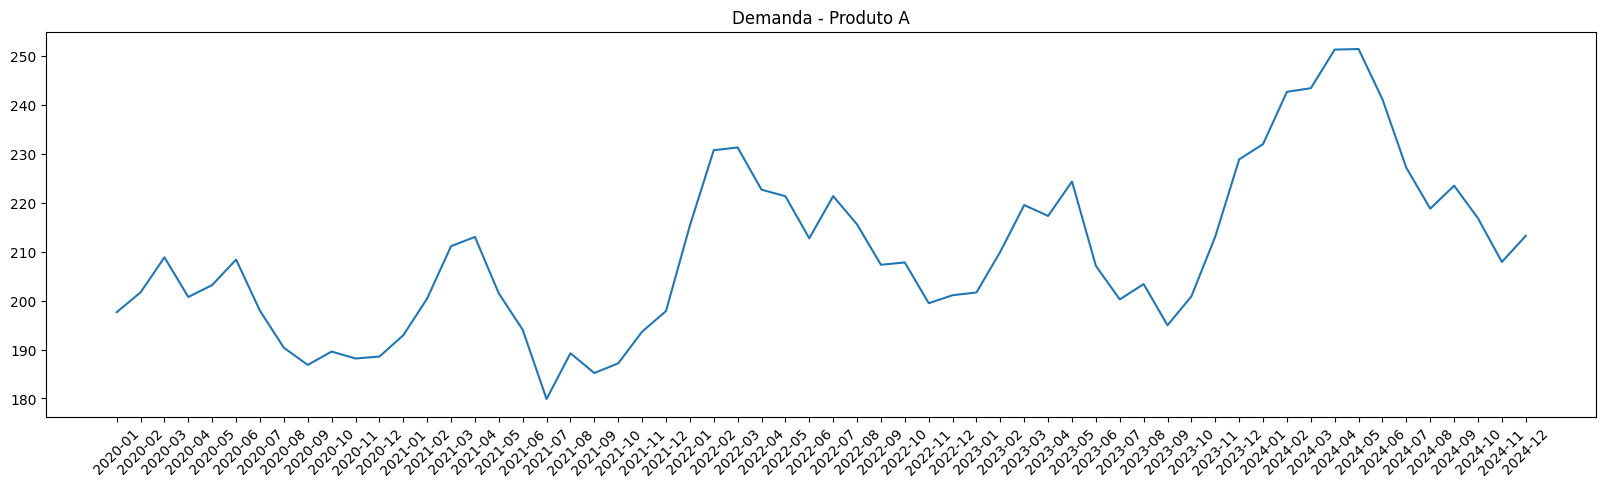

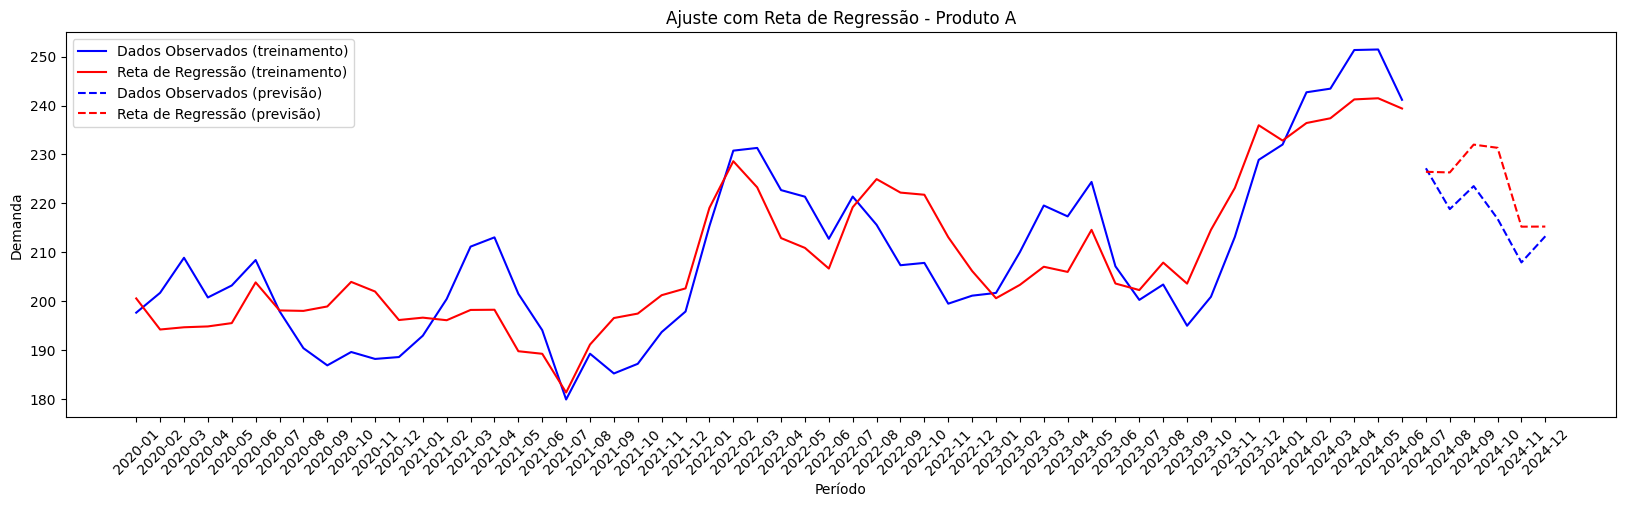

Raiz quadrada do error quadrático médio (RMSE):  11.381905844142675
Erro absoluto médio (MAE):  9.422848608722425
AIC do modelo ARIMA( 4 , 1 , 4 ): 268.4813


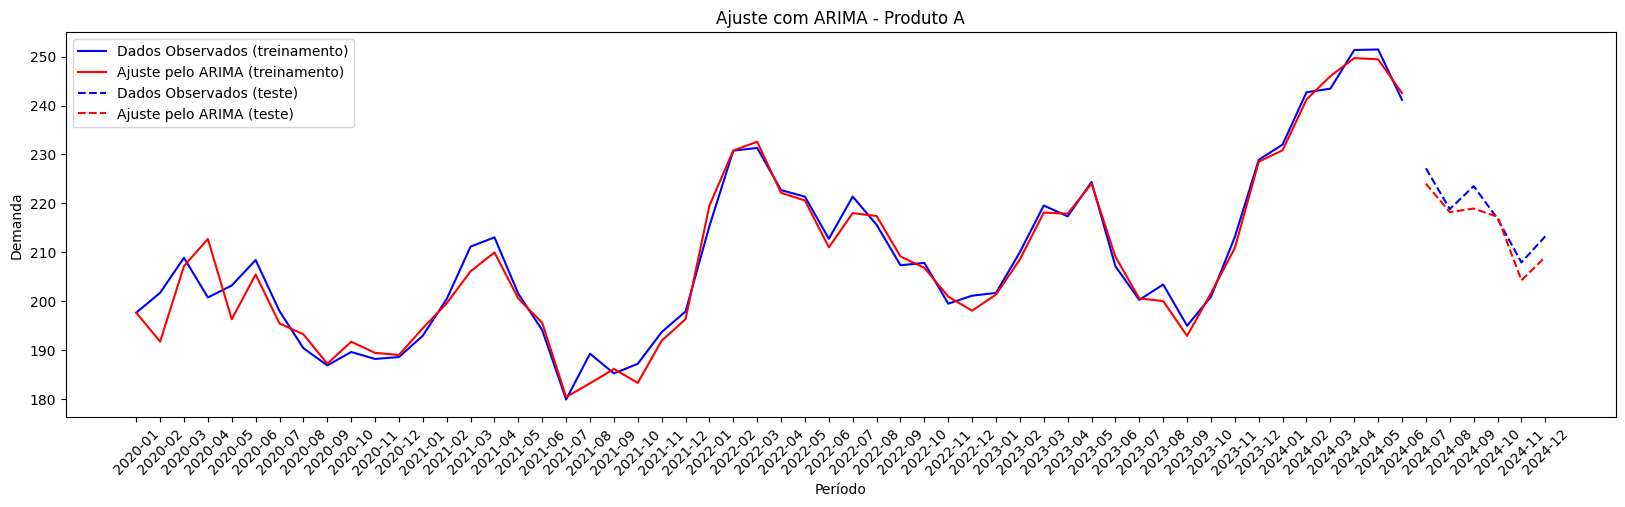

Raiz quadrada do error quadrático médio (RMSE):  3.2346983527463973
Erro absoluto médio (MAE):  2.7744125042371195


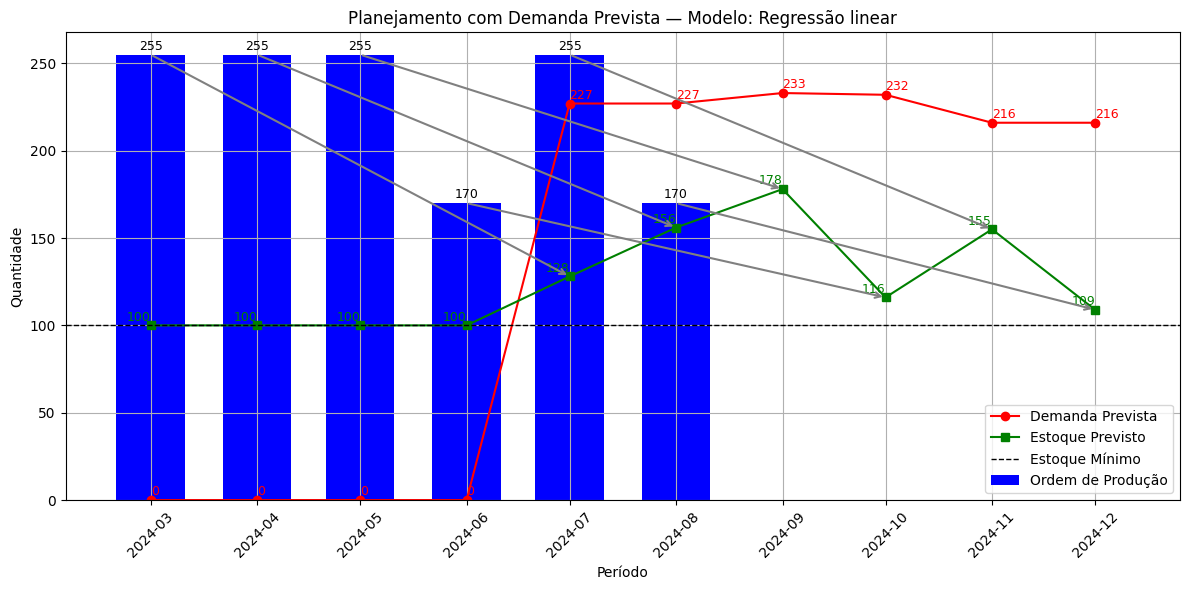

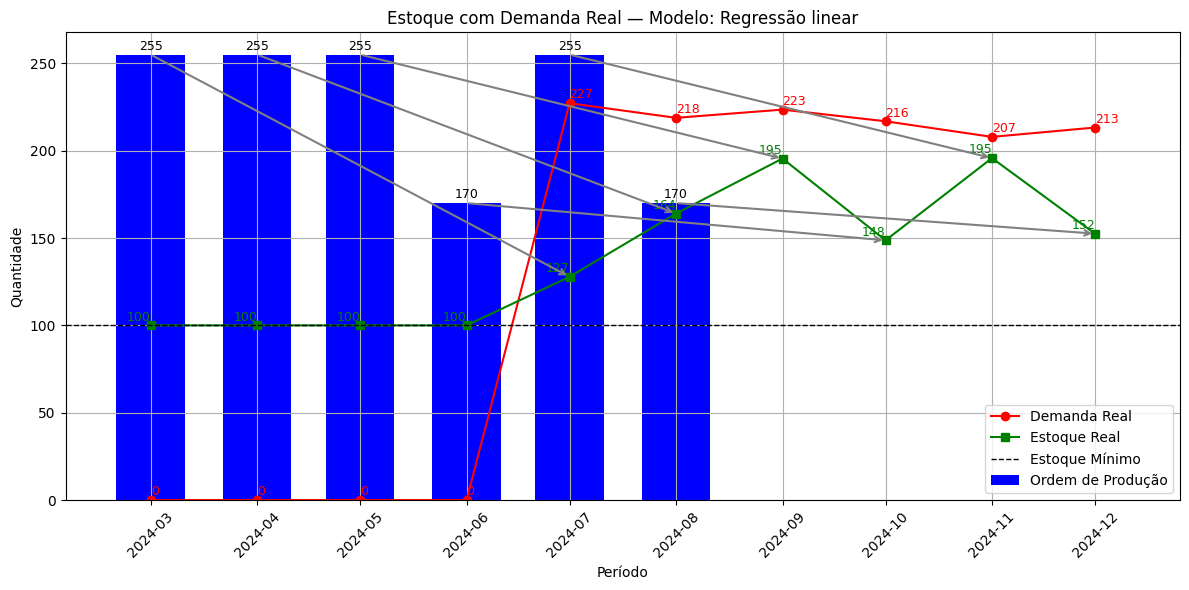

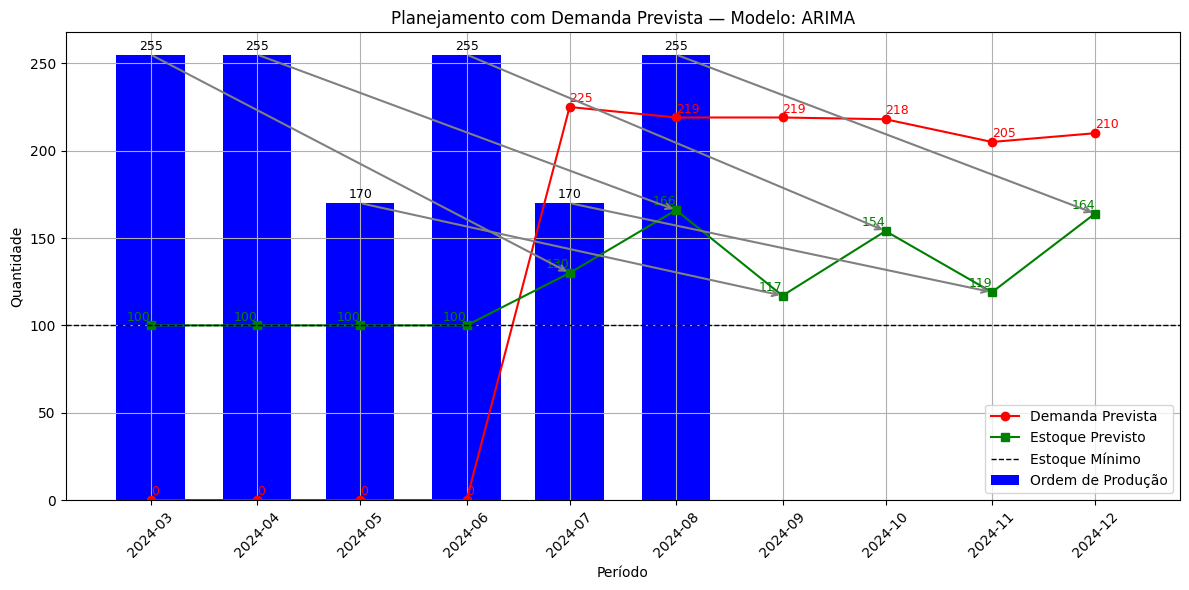

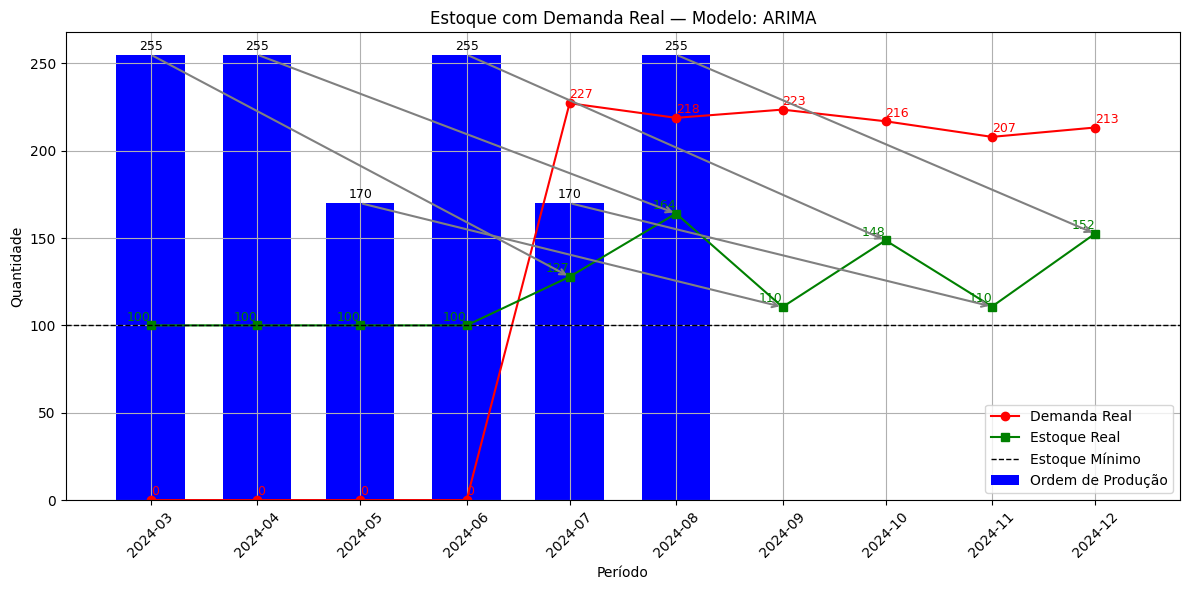

In [10]:
# Leitura da base de dados
dados,demanda,demanda_train,demanda_test,colunas,Nprev,indice_serie,exogena,exog_train,exog_test,parametros = leitura_dados()

# Previsões - Regressão linear
prev_regressao = regressao_linear(demanda_train,demanda_test,dados,colunas,indice_serie,exogena,exog_train,exog_test)

# Previsões - ARIMA
prev_arima = modelo_arima(demanda_train,demanda_test,dados,colunas,indice_serie,exogena,exog_train,exog_test)

# Cálculo do planejamento de produção e plot dos gráficos
previsoes = pd.DataFrame(index=demanda_test.index)
previsoes['Regressão linear'] = prev_regressao
previsoes['ARIMA'] = prev_arima

# Arredondando para o inteiro acima mais próximo
previsoes['Regressão linear'] = np.ceil(previsoes['Regressão linear'])
previsoes['ARIMA'] = np.ceil(previsoes['ARIMA'])

calculo_pcp(parametros,previsoes,'Regressão linear',demanda_test,indice_serie, colunas)
calculo_pcp(parametros,previsoes,'ARIMA',demanda_test,indice_serie, colunas)